In [37]:
from fastai.text.all import *
from pathlib import Path
import random

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

In [38]:
def get_oversampled_df(data_path):
    df = pd.read_csv(data_path)

    max_dialog = df['speaker'].value_counts().max()

    dfs_oversampled = [df]
    for _, group in df.groupby('speaker'):
        rand_mult = random.uniform(0.85, 1.15)
        sample_amt_to_max = max_dialog - len(group)
        dfs_oversampled.append(group.sample(int(sample_amt_to_max * rand_mult), replace=True))
    return pd.concat(dfs_oversampled)

<Axes: >

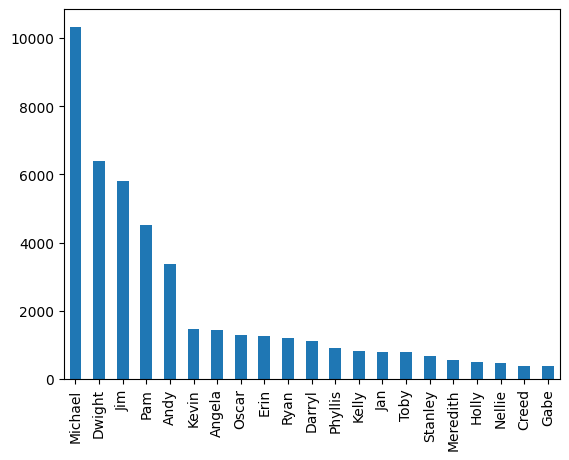

In [39]:
data_path = Path('../data/train21_shuffled.csv')
df = pd.read_csv(data_path)

df['speaker'].value_counts().plot(kind='bar')


In [40]:
dls_lm = TextDataLoaders.from_df(df, text_col='line_text', is_lm=True, valid_pct=0.1, shuffle=True)

In [41]:
dls_lm.show_batch()

,text,text_
0,"xxbos xxmaj the city of xxmaj xxunk . xxbos xxmaj man , what is taking xxmaj toby so long ? xxbos xxmaj for - okay , okay here 's what xxmaj i 'm gon na do . xxmaj i 'm going to write 4 checks for $ 1 , xxrep 3 0 each . xxmaj i 'm going to date them one year apart . xxmaj now , you are to use","xxmaj the city of xxmaj xxunk . xxbos xxmaj man , what is taking xxmaj toby so long ? xxbos xxmaj for - okay , okay here 's what xxmaj i 'm gon na do . xxmaj i 'm going to write 4 checks for $ 1 , xxrep 3 0 each . xxmaj i 'm going to date them one year apart . xxmaj now , you are to use one"
1,xxbos xxmaj yes . xxbos [ raises hand ] i want to . xxbos xxmaj better theory . xxmaj this is her ex - boyfriend and they went through some kind of painful breakup . xxbos xxmaj then make him pitch to you . xxbos xxmaj nope . xxmaj totally private . xxmaj you can say whatever is in your heart . [ jan hangs up ] xxbos xxmaj i 'd like,xxmaj yes . xxbos [ raises hand ] i want to . xxbos xxmaj better theory . xxmaj this is her ex - boyfriend and they went through some kind of painful breakup . xxbos xxmaj then make him pitch to you . xxbos xxmaj nope . xxmaj totally private . xxmaj you can say whatever is in your heart . [ jan hangs up ] xxbos xxmaj i 'd like everybody
2,"did you already , um , forward to a whole bunch of people ? xxbos [ raises hand ] xxmaj conference room ? xxbos xxmaj you mean the clients you stole from us . xxbos xxmaj chicken fight ! xxbos xxmaj good . xxbos xxmaj ok . xxmaj erin i think you know xxmaj i 've been dating someone . xxbos xxmaj marry me xxmaj holly . xxbos xxmaj yeah , they","you already , um , forward to a whole bunch of people ? xxbos [ raises hand ] xxmaj conference room ? xxbos xxmaj you mean the clients you stole from us . xxbos xxmaj chicken fight ! xxbos xxmaj good . xxbos xxmaj ok . xxmaj erin i think you know xxmaj i 've been dating someone . xxbos xxmaj marry me xxmaj holly . xxbos xxmaj yeah , they do"
3,"we just hold off with the human pyramids for a while ? xxbos xxmaj and you are ' xxbos xxmaj um , yes . xxmaj throw them away in the recycling bin . xxbos xxmaj really ? xxbos xxmaj michael . [ michael throws xxmaj phyllis ' keys under the car . ] xxbos xxmaj so i just lean over this thing and then you 'll add the water special effect later","just hold off with the human pyramids for a while ? xxbos xxmaj and you are ' xxbos xxmaj um , yes . xxmaj throw them away in the recycling bin . xxbos xxmaj really ? xxbos xxmaj michael . [ michael throws xxmaj phyllis ' keys under the car . ] xxbos xxmaj so i just lean over this thing and then you 'll add the water special effect later ?"
4,"it weigh ? xxbos [ points to smoke ] xxmaj oh , my xxmaj god ! xxmaj uh , xxmaj oh my xxmaj god ! xxbos [ through phone ] xxmaj it 's been so long since xxmaj i 've been with adults . i am so excited to see everybody . xxmaj creed , xxmaj ryan . xxmaj oh my xxmaj god , xxmaj stanley ! xxmaj stanley 's going to","weigh ? xxbos [ points to smoke ] xxmaj oh , my xxmaj god ! xxmaj uh , xxmaj oh my xxmaj god ! xxbos [ through phone ] xxmaj it 's been so long since xxmaj i 've been with adults . i am so excited to see everybody . xxmaj creed , xxmaj ryan . xxmaj oh my xxmaj god , xxmaj stanley ! xxmaj stanley 's going to be"
5,"too big for her lap . xxbos xxmaj again ? xxmaj we do that every year . xxbos i had to . i needed defense . xxbos xxmaj uh , you know what ? i think that this … uh , this is probably a misunderstanding . xxbos xxmaj what ? xxbos xxmaj the purse girl hits everything on my xxunk . xxmaj xxunk skin . xxmaj straight teeth . xxmaj curly","big for her lap . xxbos xxmaj again ? xxmaj we do that every year . xxbos i had to . i needed defense . xxbos xxmaj uh , you know what ? i think that this … uh , this is probably a misunderstanding . xxbos xxmaj what ? xxbos xxmaj the purse girl hits everything on my xxunk . xxmaj xxunk skin . xxmaj straight teeth . xxmaj curly hair"
6,"then turn those into xxunk ,

In [42]:
data_dir = Path('../data')
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], wd=0.1, path=data_dir)

In [43]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.976534,3.509052,0.312032,33.416561,00:25
1,3.627972,3.416544,0.321774,30.463963,00:25
2,3.504795,3.389803,0.327565,29.660120,00:25
3,3.429511,3.366713,0.330215,28.983110,00:25
4,3.374247,3.361649,0.330832,28.836699,00:25


In [44]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.402158,3.393936,0.325852,29.782938,00:25
1,3.447440,3.393872,0.327565,29.781042,00:25
2,3.391063,3.379286,0.327885,29.349810,00:25
3,3.338911,3.361836,0.330661,28.842110,00:25
4,3.293164,3.358517,0.331289,28.746540,00:25


In [45]:
learn.save_encoder('finetuned_10epoch_raw_data')

In [50]:
df_oversampled = get_oversampled_df(data_path)
dls_clas = TextDataLoaders.from_df(df_oversampled, text_col='line_text', label_col='speaker', shuffle_train=True, text_vocab=dls_lm.vocab)

In [51]:
dls_clas.show_batch()

,text,category
0,"xxbos xxmaj i 've really learned from the xxunk . xxmaj the great xxunk , xxmaj drew xxmaj xxunk , xxmaj ryan xxmaj xxunk , uh , the xxmaj xxunk guy not so much . xxmaj he 's more the signing , xxmaj wayne xxmaj xxunk . xxmaj um , xxmaj robin xxmaj williams . xxmaj oh , man , would i love to go head - to - head with him . xxmaj oh ! xxmaj that would be exciting . [ as xxmaj robin xxmaj williams ] ' hi . xxmaj i 'm xxmaj xxunk from xxmaj xxunk . ' xxmaj well , xxmaj i 'm xxmaj xxunk from xxmaj xxunk . xxmaj nanoo , nanoo . xxmaj xxunk , xxunk . [ as xxmaj robin xxmaj williams ] ' that 's xxmaj good morning , xxmaj vietnam ! ' xxmaj well , hello to you . xxmaj",Michael
1,"xxbos xxmaj no . xxmaj no , that is not all . xxmaj let me tell you what real life is like . xxmaj the men dry up , and the nights get lonely . xxmaj the only calls on your machine are for collection xxunk about that pair of motorcycle boots you never even wore . xxmaj you xxunk your old high school boyfriend online , go to his daughter 's soccer games , and make a scene . xxmaj you buy a diamond ring for yourself , wear it on your right hand , and tell yourself , you 're all you need . xxmaj one day , you 're alone , tired . xxmaj at your feet , a dying bird . xxmaj but where did it come from ? xxmaj why did you kill it ? xxmaj is it because in some strange way it is",Nellie
2,"xxbos xxmaj well , uh , okay . xxmaj um . xxmaj it 's really great to be here tonight , with the xxmaj ferris wheel , the band , and the low sunlight . xxmaj i 'm gon na miss you all when i go to xxmaj costa xxmaj rica , and if i keep drinking beer like this , xxmaj i 'm gon na have to take a leak - a. [ laughter from audience , xxmaj michael looks at camera xxunk ] xxmaj look , on a more personal note , i just want to say thanks , you know , no matter what was going on in my life , you know , my divorce , or the xxunk battle , or that thing with my sister , it was just nice knowing i had a , a xxunk place to come to where …",Toby
3,"xxbos [ to xxmaj andy ] i talked to corporate . xxmaj turns out there have been 12 reports of xxunk printers . xxmaj out of 400 , xxrep 3 0 . [ smiles ] xxmaj we 've xxunk . xxmaj every time it 's been user error . xxmaj they block the xxunk or something , i do n't know . xxmaj that 's why we have the fine print . xxmaj thank you for bringing this to our attention . xxmaj so xxmaj i 'd like to reward you for that . [ pulls out gift card ] xxmaj that 's god for five bucks at xxmaj dunkin ' xxmaj donuts . xxmaj any xxmaj dunkin ' xxmaj donuts . [ andy looks over at xxmaj darryl and xxmaj darryl motions for xxmaj andy to go to him ]",Gabe
4,"xxbos xxmaj oui , xxmaj oui , xxmaj monsieur . xxmaj from the xxmaj xxunk region , a nice firm xxunk . xxmaj also from the great state of xxmaj xxunk , an aged xxunk . xxmaj here you will find a xxunk style spread which has xxunk nicely with the air to form a light xxunk which i think you 'll find both challenging and delicious . xxmaj at that point , i would recommend you take a trip south of the border to the great state of xxmaj xxunk where you will find this fine xxmaj xxunk xxmaj cheese dressing . xxmaj if i may be so bold , it 's a lot of fun to let the xxunk take a little swim in the xxunk cheese . xxmaj bon appetit .",Andy
5,"xxbos [ crying ] i ca n't do this . xxmaj all the xxunk are gon na be different there . xxmaj i 'm not gon na be able to find my shows . xxmaj i 'm not going to start improv at level one , and i do n't think my xxunk will transfer . xxmaj ugh , and you know what ? i just figured out where i was supposed to go to vote . [ picks xxmaj world 's xxmaj best xxmaj boss mug out of the xxunk and puts it back on his desk ] i got ta call her , and xxmaj i 'm going to tell her , that i can not come . [ dials on his phone ]",Michael
6,"xxbos xxmaj last night was crazy . xxmaj xxunk ? xxmaj yeah . xxmaj he did a donut in a parking lot in front of a cop . xxmaj and then he yells , ' hey co

In [54]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, metrics=accuracy, drop_mult=0.5, path=data_dir)

In [55]:
learn.load_encoder('finetuned_10epoch_raw_data')

Use discriminative learning and gradual unfreezing to benefit from the LM fine tuning

In [56]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.858639,2.824856,0.167565,00:38


In [57]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.273873,1.996141,0.413717,00:43


In [58]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4), 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.723844,1.341638,0.598730,01:02


In [59]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.471472,1.125690,0.659868,01:20
1,1.299848,1.039159,0.684808,01:20


In [60]:
learn.save('gradual_unfreeze')

Path('../data/models/gradual_unfreeze.pth')

In [61]:
learn.fine_tune(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.379189,1.041239,0.681337,00:47


epoch,train_loss,valid_loss,accuracy,time
0,1.212348,0.922801,0.715366,01:19
1,1.124359,0.832202,0.739140,01:20
2,0.984608,0.768485,0.760403,01:19
3,0.802514,0.691501,0.783378,01:19
4,0.753672,0.605773,0.806696,01:19
5,0.645452,0.569023,0.819691,01:17
6,0.535576,0.521517,0.832755,01:17
7,0.442816,0.508448,0.838670,01:17
8,0.477323,0.505606,0.842507,01:17
9,0.539282,0.498451,0.844882,01:17


In [62]:
learn.fine_tune(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.566147,0.519057,0.837300,00:48


epoch,train_loss,valid_loss,accuracy,time
0,0.618788,0.512606,0.839926,01:19
1,0.477238,0.528741,0.839880,01:19
2,0.546472,0.538952,0.835153,01:19
3,0.557759,0.532016,0.838053,01:20
4,0.507332,0.528189,0.842826,01:20
5,0.479780,0.515114,0.845658,01:20
6,0.401412,0.505492,0.850477,01:20
7,0.437480,0.515497,0.852784,01:23
8,0.341165,0.512568,0.854543,01:20
9,0.335571,0.513160,0.854246,01:21


In [63]:
learn.fine_tune(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.375447,0.546352,0.847006,00:49


epoch,train_loss,valid_loss,accuracy,time
0,0.497221,0.536701,0.848764,01:19
1,0.484544,0.542147,0.848056,01:20
2,0.490150,0.532574,0.848627,01:20
3,0.468272,0.518920,0.853835,01:20
4,0.359040,0.521633,0.854451,01:20


In [65]:
learn.export('ULMFit_train_oversampled_30_epoch')

In [66]:
interp = ClassificationInterpretation.from_learner(learn)

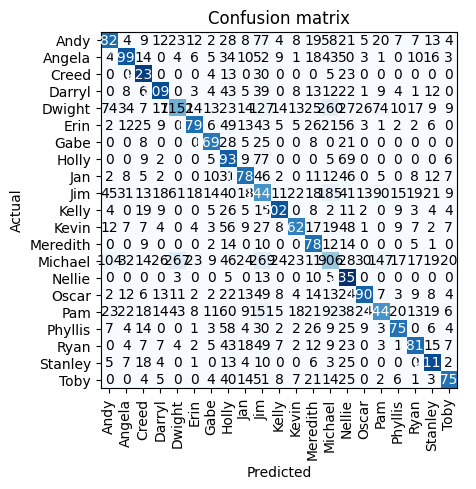

In [68]:
interp.plot_confusion_matrix()

In [70]:
learn.show_results()

,text,category,category_
0,"xxbos xxmaj yes . xxmaj actually , i have . i have been on a hunting trip . i shot a deer in the leg . i had to … i had to hit him , i had to hit him with a shovel for about an hour , so he … xxmaj that 's good eating , though . xxmaj xxunk 's very xxunk . xxmaj it 's hard to watch , though . xxmaj it 's hard to … xxmaj it 's hard to hit another living thing in the face with a shovel for about an hour . xxmaj that … i have n't been hunting since then . xxup i , i … 'cause that 's , you know , where 's the joy in that ? xxmaj where 's the … xxmaj there 's no sport , really . xxmaj especially when you 're the",Michael,Michael
1,"xxbos [ answering phone ] xxmaj this is xxmaj angela . xxmaj oh . xxmaj hello , xxmaj miss xxmaj xxunk . xxmaj uh , how can i help you ? xxmaj did my rent check not clear ? xxmaj because i just transferred another $ 25 to that account . xxmaj so if there 's a problem it 's clearly on your end . xxmaj xxunk . xxmaj oh . xxmaj oh , okay . xxmaj good . xxmaj then … um ' what is this about ? xxmaj no , no . xxmaj hey , hey ! xxmaj no , you are out of line xxmaj miss xxmaj xxunk . xxmaj no , no you are . xxmaj no you are ! xxmaj xxunk ? xxmaj fine ! i did n't want to live in that xxunk anyway ! xxmaj listen , i get my security deposit back",Angela,Angela
2,"xxbos xxmaj well , uh , okay . xxmaj um . xxmaj it 's really great to be here tonight , with the xxmaj ferris wheel , the band , and the low sunlight . xxmaj i 'm gon na miss you all when i go to xxmaj costa xxmaj rica , and if i keep drinking beer like this , xxmaj i 'm gon na have to take a leak - a. [ laughter from audience , xxmaj michael looks at camera xxunk ] xxmaj look , on a more personal note , i just want to say thanks , you know , no matter what was going on in my life , you know , my divorce , or the xxunk battle , or that thing with my sister , it was just nice knowing i had a , a xxunk place to come to where …",Toby,Toby
3,"xxbos [ to xxmaj andy ] i talked to corporate . xxmaj turns out there have been 12 reports of xxunk printers . xxmaj out of 400 , xxrep 3 0 . [ smiles ] xxmaj we 've xxunk . xxmaj every time it 's been user error . xxmaj they block the xxunk or something , i do n't know . xxmaj that 's why we have the fine print . xxmaj thank you for bringing this to our attention . xxmaj so xxmaj i 'd like to reward you for that . [ pulls out gift card ] xxmaj that 's god for five bucks at xxmaj dunkin ' xxmaj donuts . xxmaj any xxmaj dunkin ' xxmaj donuts . [ andy looks over at xxmaj darryl and xxmaj darryl motions for xxmaj andy to go to him ]",Gabe,Gabe
4,"xxbos xxmaj xxunk and xxmaj mary are seated watching the show . [ in xxmaj lincoln voice ] xxmaj oh xxmaj mary this is wonderful ' xxmaj ok xxmaj mary stop your xxunk . xxmaj i 'll be quiet . [ aside to the audience ] i need her like i need a hole in the head ! [ scattered chuckles from the crowd ] [ gabe raises his hand with a finger pointed in the shape of a gun to his head ] xxup bang ! xxmaj ooh [ gabe falls to the ground and the crowd claps , xxmaj gabe picks up the xxmaj lincoln hat , bows , runs to the crowd and xxunk it back for his pink ' dm does xxup xxunk ' hat and runs off ]",Gabe,Gabe
5,"xxbos xxmaj this is awesome . [ cell phone rings ] xxmaj sorry . xxmaj hi , xxmaj gabe . xxmaj yeah , i just stopped by xxmaj andy 's cast party to say hi to everyone . xxmaj oh , sure , i can pick you up some soup . xxmaj what do you want ? xxmaj that 's xxunk , xxmaj gabe . xxmaj okay , i - i'll see you soup . [ hangs up ] xxmaj okay , i have to go . xxmaj thank you so much . xxmaj this is so much fun , and xxmaj i 'm really sorry that i missed your play , but next time xxmaj i 'll be there . xxmaj or here . xxmaj right here , i promise .",Erin,Erin
6,"xxbos [ plays the recorder ] xxmaj that was xxmaj xxunk . a traditional xxmaj english xxmaj xxunk about the xxunk xxmaj xxunk xxmaj xxunk . xxmaj and now , a very special treat … a book my xxmaj xxunk used to

In [79]:
learn.predict('I wanna eat hot dogs on the beach')

('Kevin',
 tensor(11),
 tensor([5.7813e-02, 1.4340e-04, 2.0838e-03, 2.2418e-03, 1.8366e-02, 1.2175e-03,
         7.3574e-04, 2.1196e-03, 9.9496e-04, 1.5417e-02, 2.7751e-02, 6.1350e-01,
         1.1828e-03, 1.2733e-01, 1.6898e-04, 3.1880e-04, 9.9527e-02, 3.3881e-04,
         1.7241e-03, 1.3479e-02, 1.3544e-02]))